## CarND Project 3: Bahavior Cloning




### Overview

Objective of this project is to develop a deep learning based algorithm to mimic driving behavior of human. Sample data from Udacity P3 datasets were used. Learned from previous project, I know that data augmentation is very important. So I then used image augmentation to generate multiple training samples that represented driving under different driving conditions. These data augmentation methods include cropping to remove background areas like trees. 

 


### Results: 

Once I got the steering angles, I increased the value of the steering angle by 20% (multiplied by 1.2) to make the car more responsive. The main reason to do so was while training I went over the edges a few times, and corrected. I wanted the car to avoid those mistakes, so used higher gain on steering angle. 



#### Behavior cloning of human driving. 

Model for track 1 can be ran using the command, 

```
python drive.py model.h5 run1
```


Video below presents performance of the algorithm on the first track. No simulator parameters were changed in this case. The neural network based controller was able to drive the car around the track on its own. 

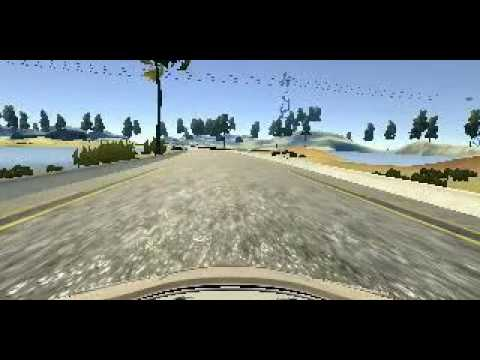

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("RfYxGC9WYEs")

## Python code for generating the trainer

### Importing packages

In [1]:
### Importing packages. 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math


### Functions to calculate moving average and compute butterworth filter.


I wrote these functions to calculate smoother steering data. I used moving average filter to smooth steering angle. 

In [2]:
def butter_lowpass(x,fcut,f_sample,order,plen): 
    # x: unfilteted data
    # fcut : cutoff frequency
    # f_sample : sampling frequency
    # order : Order of filter (usually 4)
    # plen: padding length (typically left as 0)
    
    rat = fcut/f_sample

    b, a = signal.butter(order, rat)
    y = signal.filtfilt(b, a, x, padlen=plen)
    return y

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

### Loading data

In [9]:
csv_path = './data/driving_log.csv'
data_files_s = pd.read_csv(csv_path, header =None,
                         names=['center','left','right','steering','throttle','brake','speed'],
                        skiprows = [0],
                        index_col = False)


In [10]:
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:
print("Dataframe:")
display(data_files_s[50:100])

Dataframe:


center  \
50  IMG/center_2016_12_01_13_32_43_357.jpg   
51  IMG/center_2016_12_01_13_32_43_457.jpg   
52  IMG/center_2016_12_01_13_32_43_558.jpg   
53  IMG/center_2016_12_01_13_32_43_659.jpg   
54  IMG/center_2016_12_01_13_32_43_761.jpg   
55  IMG/center_2016_12_01_13_32_43_862.jpg   
56  IMG/center_2016_12_01_13_32_43_963.jpg   
57  IMG/center_2016_12_01_13_32_44_064.jpg   
58  IMG/center_2016_12_01_13_32_44_165.jpg   
59  IMG/center_2016_12_01_13_32_44_266.jpg   
60  IMG/center_2016_12_01_13_32_44_368.jpg   
61  IMG/center_2016_12_01_13_32_44_468.jpg   
62  IMG/center_2016_12_01_13_32_44_569.jpg   
63  IMG/center_2016_12_01_13_32_44_671.jpg   
64  IMG/center_2016_12_01_13_32_44_772.jpg   
65  IMG/center_2016_12_01_13_32_44_873.jpg   
66  IMG/center_2016_12_01_13_32_44_974.jpg   
67  IMG/center_2016_12_01_13_32_45_074.jpg   
68  IMG/center_2016_12_01_13_32_45_174.jpg   
69  IMG/center_2016_12_01_13_32_45_275.jpg   
70  IMG/center_2016_12_01_13_32_45_377.jpg   
71  IMG/center_2016_12_01_13_32_45_477.jpg   
72  IMG/center_2016_12_01_13_32_45_578.jpg   
73  IMG/center_2016_12_01_13_32_45_679.jpg   
74  IMG/center_2016_12_01_13_32_45_780.jpg   
75  IMG/center_2016_12_01_13_32_45_881.jpg   
76  IMG/center_2016_12_01_13_32_45_982.jpg   
77  IMG/center_2016_12_01_13_32_46_084.jpg   
78  IMG/center_2016_12_01_13_32_46_185.jpg   
79  IMG/center_2016_12_01_13_32_46_285.jpg   
80  IMG/center_2016_12_01_13_32_46_385.jpg   
81  IMG/center_2016_12_01_13_32_46_486.jpg   
82  IMG/center_2016_12_01_13_32_46_587.jpg   
83  IMG/center_2016_12_01_13_32_46_689.jpg   
84  IMG/center_2016_12_01_13_32_46_789.jpg   
85  IMG/center_2016_12_01_13_32_46_890.jpg   
86  IMG/center_2016_12_01_13_32_46_991.jpg   
87  IMG/center_2016_12_01_13_32_47_091.jpg   
88  IMG/center_2016_12_01_13_32_47_192.jpg   
89  IMG/center_2016_12_01_13_32_47_293.jpg   
90  IMG/center_2016_12_01_13_32_47_394.jpg   
91  IMG/center_2016_12_01_13_32_47_495.jpg   
92  IMG/center_2016_12_01_13_32_47_595.jpg   
93  IMG/center_2016_12_01_13_32_47_695.jpg   
94  IMG/center_2016_12_01_13_32_47_797.jpg   
95  IMG/center_2016_12_01_13_32_47_897.jpg   
96  IMG/center_2016_12_01_13_32_47_998.jpg   
97  IMG/center_2016_12_01_13_32_48_098.jpg   
98  IMG/center_2016_12_01_13_32_48_200.jpg   
99  IMG/center_2016_12_01_13_32_48_302.jpg   

                                     left  \
50   IMG/left_2016_12_01_13_32_43_357.jpg   
51   IMG/left_2016_12_01_13_32_43_457.jpg   
52   IMG/left_2016_12_01_13_32_43_558.jpg   
53   IMG/left_2016_12_01_13_32_43_659.jpg   
54   IMG/left_2016_12_01_13_32_43_761.jpg   
55   IMG/left_2016_12_01_13_32_43_862.jpg   
56   IMG/left_2016_12_01_13_32_43_963.jpg   
57   IMG/left_2016_12_01_13_32_44_064.jpg   
58   IMG/left_2016_12_01_13_32_44_165.jpg   
59   IMG/left_2016_12_01_13_32_44_266.jpg   
60   IMG/left_2016_12_01_13_32_44_368.jpg   
61   IMG/left_2016_12_01_13_32_44_468.jpg   
62   IMG/left_2016_12_01_13_32_44_569.jpg   
63   IMG/left_2016_12_01_13_32_44_671.jpg   
64   IMG/left_2016_12_01_13_32_44_772.jpg   
65   IMG/left_2016_12_01_13_32_44_873.jpg   
66   IMG/left_2016_12_01_13_32_44_974.jpg   
67   IMG/left_2016_12_01_13_32_45_074.jpg   
68   IMG/left_2016_12_01_13_32_45_174.jpg   
69   IMG/left_2016_12_01_13_32_45_275.jpg   
70   IMG/left_2016_12_01_13_32_45_377.jpg   
71   IMG/left_2016_12_01_13_32_45_477.jpg   
72   IMG/left_2016_12_01_13_32_45_578.jpg   
73   IMG/left_2016_12_01_13_32_45_679.jpg   
74   IMG/left_2016_12_01_13_32_45_780.jpg   
75   IMG/left_2016_12_01_13_32_45_881.jpg   
76   IMG/left_2016_12_01_13_32_45_982.jpg   
77   IMG/left_2016_12_01_13_32_46_084.jpg   
78   IMG/left_2016_12_01_13_32_46_185.jpg   
79   IMG/left_2016_12_01_13_32_46_285.jpg   
80   IMG/left_2016_12_01_13_32_46_385.jpg   
81   IMG/left_2016_12_01_13_32_46_486.jpg   
82   IMG/left_2016_12_01_13_32_46_587.jpg   
83   IMG/left_2016_12_01_13_32_46_689.jpg   
84   IMG/left_2016_12_01_13_32_46_789.jpg   
85   IMG/left_2016_12_01_13_32_46_890.jpg   
86   IMG/left_2016_12_01

#### Show statistics of steer

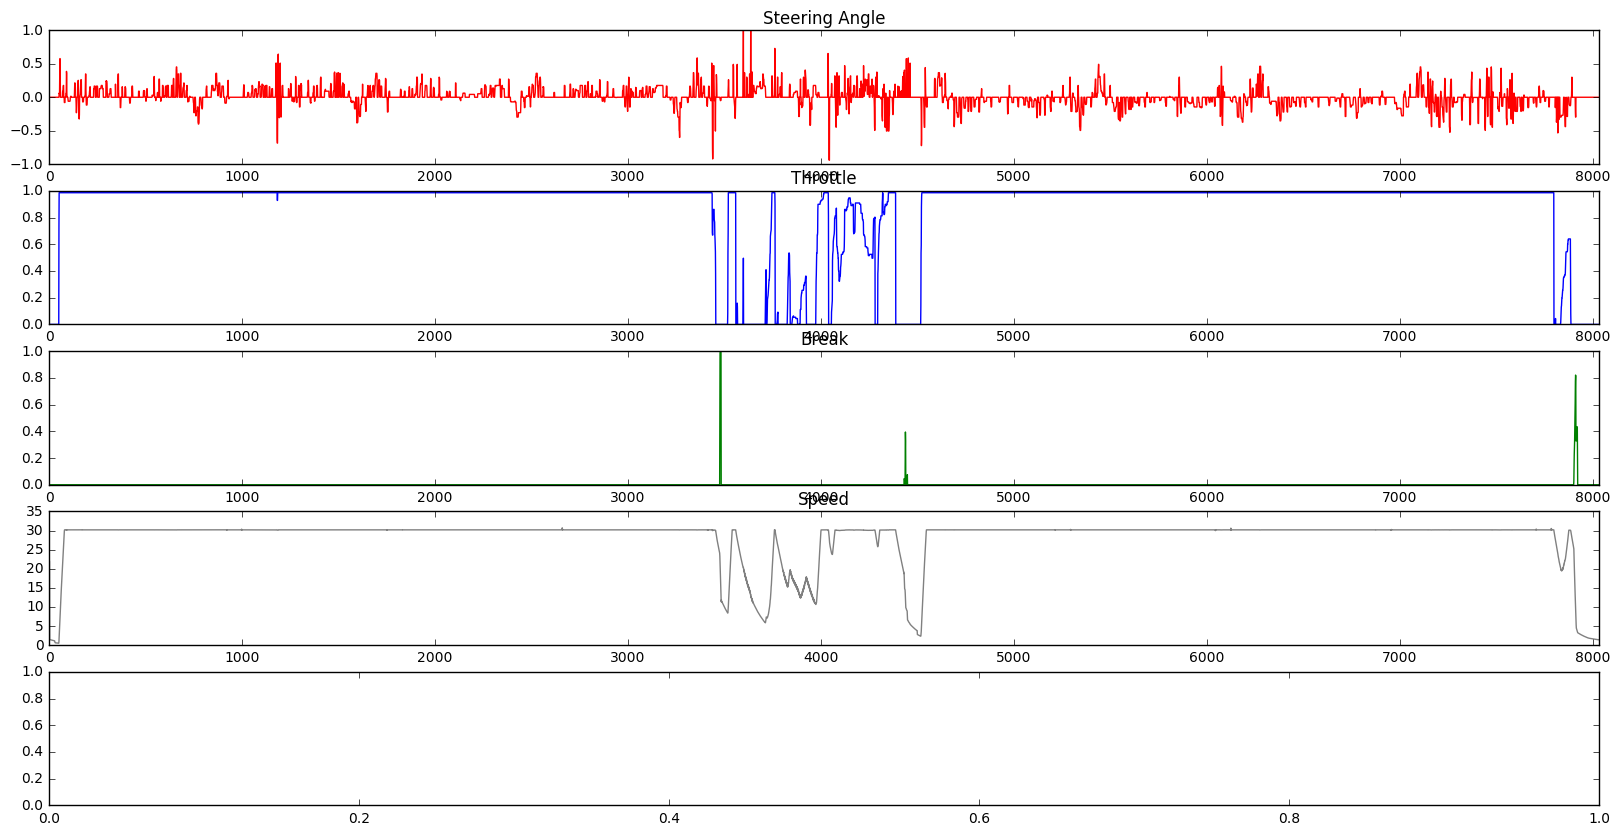

In [15]:
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(20,10))
data_files_s['steering'].plot(ax=axes[0],color='red'); axes[0].set_title('Steering Angle');
data_files_s['throttle'].plot(ax=axes[1],color='blue'); axes[1].set_title('Throttle');
data_files_s['brake'].plot(ax=axes[2],color='green'); axes[2].set_title('Break');
data_files_s['speed'].plot(ax=axes[3],color='gray'); axes[3].set_title('Speed');

#### Show steering distribution

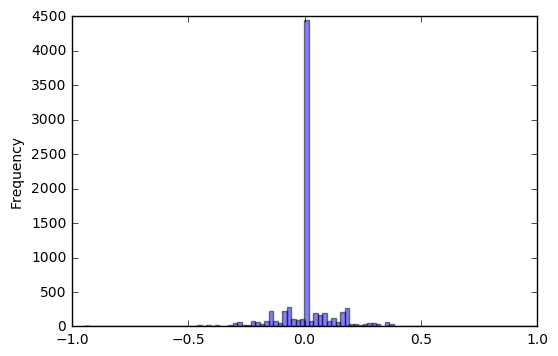

In [16]:
data_files_s['steering'].plot.hist(bins=101,alpha=0.5)

#### Removing data with speed below .25

In [17]:
ind = data_files_s['throttle']>.25
data_files_s= data_files_s[ind].reset_index()

In [18]:
len(data_files_s)


7222

#### Scale the images

In [19]:
def process_newimage_file(name):
    name = './data/' + name
    image = cv2.imread(name)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image/255.-.5
    return image

### Augmentation 1: Including LR images. 

Figure below presents images from left, center and right images. 

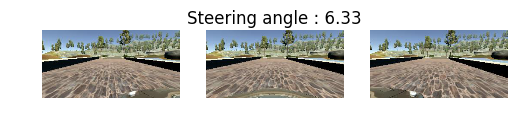

In [22]:
ind_num = 100
len_plt = 200

rev_steer_s = np.array(data_files_s.steering,dtype=np.float32)
t_s = np.arange(len(rev_steer_s))
x_s = np.array(data_files_s.steering)
y_s = rev_steer_s

steer_sm_s = rev_steer_s
image_c = process_newimage_file(data_files_s['center'][ind_num].strip())
image_r = process_newimage_file(data_files_s['right'][ind_num].strip())
image_l = process_newimage_file(data_files_s['left'][ind_num].strip())
plt.figure()
plt.subplot(1,3,1)
plt.imshow(image_l+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_c+.5);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(y_s[ind_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_r+.5);
plt.axis('off');


In figure below, I tested how to augment left and right camera angle to match center panel data. After a lot of exeprimentation, I settled with using a shift of .25. A shift of .25 corresponsds to 6.25 degrees in angle. The right camera would have to move left to come to center, and left camera would have to move right to come to center. So I added .25 to get steering angle for left camera image and subtracted .25 to compute angle for the right camera image. 

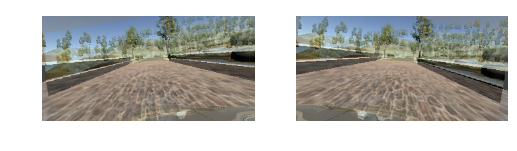

In [23]:
angle_rot = 10
trans_camera = 5


rows,cols,channels = image_c.shape

Mt = np.float32([[1,0,-trans_camera],[0,1,0]])
Mr = cv2.getRotationMatrix2D((cols/2,rows/2),-angle_rot,1)
rows,cols,channels = image_c.shape
image_c_mod = cv2.warpAffine(image_c,Mr,(cols,rows))
image_c_mod = cv2.warpAffine(image_c_mod,Mt,(cols,rows))
image_rc_mod = cv2.addWeighted(image_r,0.5,image_c_mod,0.5,0)

Mt = np.float32([[1,0,trans_camera],[0,1,0]])
Mr = cv2.getRotationMatrix2D((cols/2,rows/2),angle_rot,1)
rows,cols,channels = image_c.shape
image_c_mod = cv2.warpAffine(image_c,Mr,(cols,rows))
image_c_mod = cv2.warpAffine(image_c_mod,Mt,(cols,rows))
image_lc_mod = cv2.addWeighted(image_l,0.5,image_c_mod,0.5,0)

plt.subplot(1,2,1)
plt.imshow(image_lc_mod+.5)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image_rc_mod+.5)
plt.axis('off');

In [24]:
def plot_camera_images(data,steer_sm,ind_num,deg = 0):
    image_c = process_newimage_file(data['center'][ind_num].strip())
    image_r = process_newimage_file(data['right'][ind_num].strip())
    image_l = process_newimage_file(data['left'][ind_num].strip())
    plt.subplot(1,3,1)
    plt.imshow(image_l+.5);
    plt.axis('off')
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]+.25,2) ));
    else:
        plt.title('Steer:'+ str((np.round((steer_sm[ind_num]+.1)*180/np.pi,2) )))
    plt.subplot(1,3,2)
    plt.imshow(image_c+.5);
    plt.axis('off')
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num],2) ));
    else:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]*180/np.pi,2) ));
    plt.subplot(1,3,3)
    plt.imshow(image_r+.5);
    plt.axis('off');
    if deg==0:
        plt.title('Steer:'+ str(np.round(steer_sm[ind_num]-.25,2) ));
    else:
        plt.title('Steer:'+ str((np.round((steer_sm[ind_num]-.1)*180/np.pi,2) )))
    

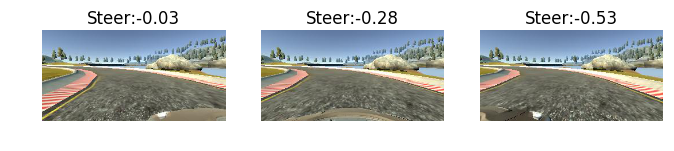

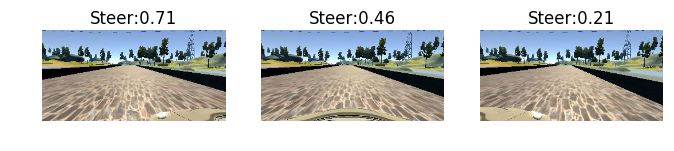

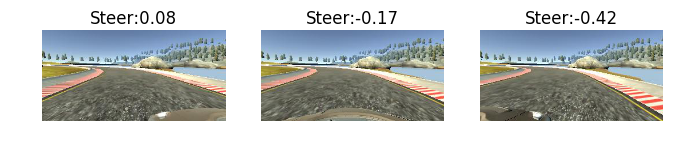

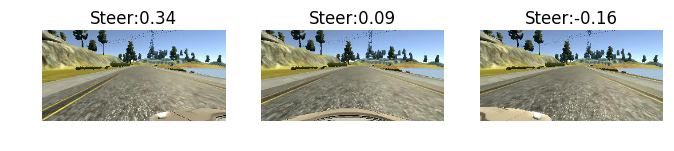

In [25]:
for i in range(4):
    i_random = np.random.randint(len(data_files_s)-1)
    plt.figure(figsize=(8,16))
    plot_camera_images(data_files_s,steer_sm_s,i_random,0)
    plt.show()


### Augmentation 2: Brightness augmentation

I next converted camera image's brightness so the car can learn to operate in both day and night conditions. To do brightness augmentation, I converted RGB image to HSV, scaled V (brightness) channel by a random number between .25 and 1.25, and converted the image back to RGB. 

In [26]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
        

In [27]:
image2 = cv2.imread('./data/' + data_files_s['center'][1].strip())
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)

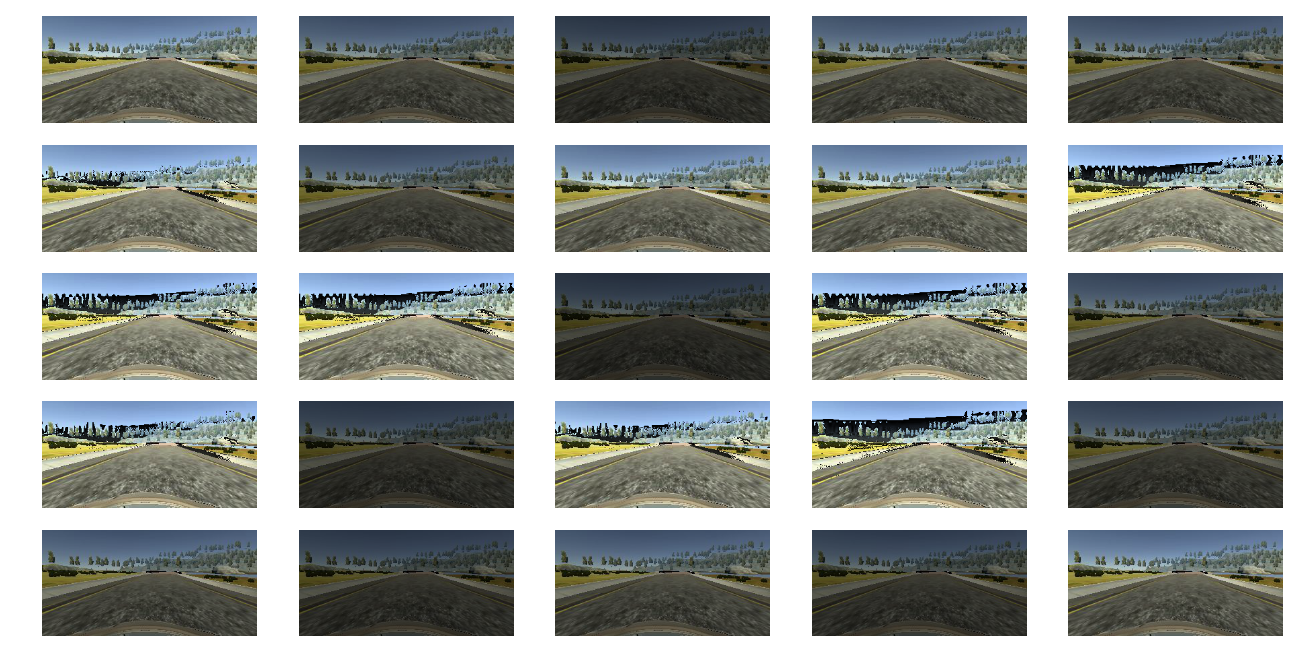

In [28]:
plt.figure(figsize=(16,8))
for i in range(25):
    image1 = augment_brightness_camera_images(image2)
    plt.subplot(5,5,i+1)
    plt.imshow(image1)
    plt.axis('off')


### Augmentation 3: Shifting left/right and up/down. 

I next shifted camera images to left and right to simulate the effect of the car at different positions in the lane. To simulate lane shifts, I applied random shifts in horizontal direction of upto 10 pixels, and applied angle change of .2 per pixel. 

In [33]:
image_ind = 85
image = cv2.imread('./data/' + data_files_s['center'][image_ind].strip())
steer = data_files_s['steering'][image_ind]
image_l = cv2.imread('./data/' + data_files_s['left'][image_ind].strip())
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_l = cv2.cvtColor(image_l,cv2.COLOR_BGR2RGB)

In [34]:
def trans_image(image,steer,trans_range):
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang,tr_x

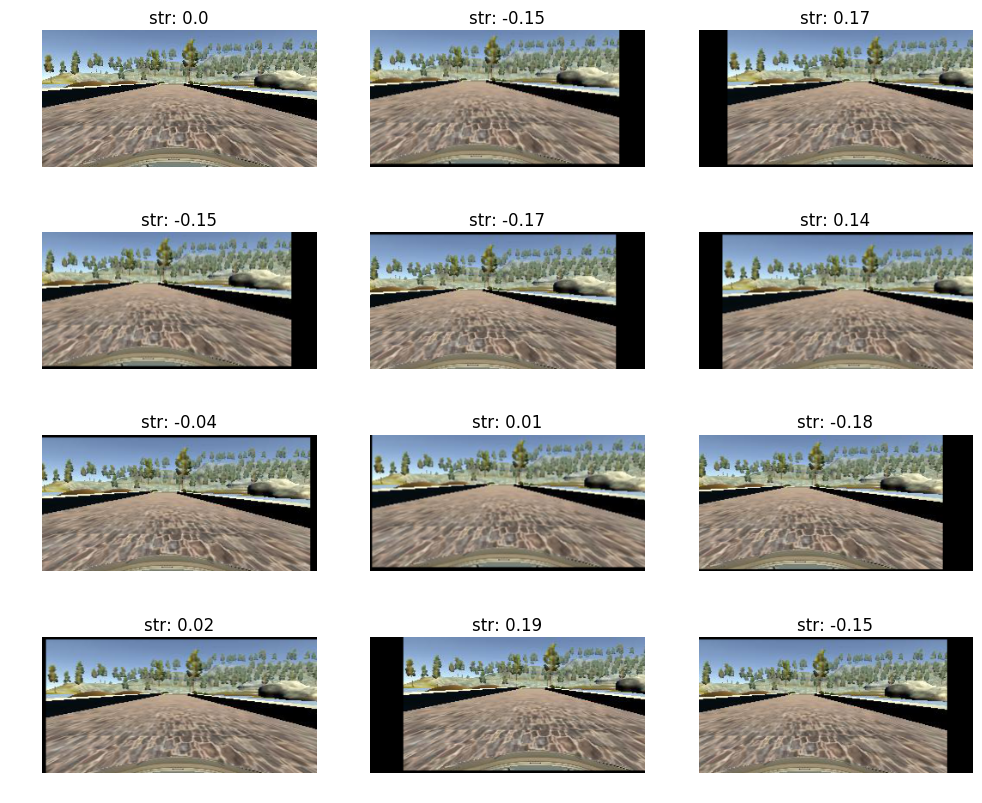

In [35]:
plt.figure(figsize=(12,10))
plt.subplot(4,3,1)
plt.imshow(image)
plt.title('str: ' + str(np.round(steer,2)))
plt.axis('off')

for i in range(11):
    plt.subplot(4,3,i+2)
    image_tr,steer_ang,tr_x = trans_image(image,steer,80)
    plt.title('str: ' + str(np.round(steer_ang,2)) )
    plt.imshow(image_tr)
    plt.axis('off');

### Augmentation 4: Flipping images

I flipped images about the vertical midline to simulate driving in the opposite direction. The data collected had a lot of left turns, so to balance the left and right turns, images were flipped about the vertical axis at random. The anges corresponding to flipped images were multiplied by -1 to correct for steering in the opposite direction. 

### Augmentation: All together

Code below presents the final augmentation scheme all put together. 


### Preprocessing

I performed simple preprocessing where I cropped the top 1/4 of the image and bottom 25 pixels. I removed bottom pixels to remove the hood of the car. I also rescaled images to 64X64, After these, the final images inputs to network look as follows. 

In [39]:
new_size_col = 64
new_size_row = 64

def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]*0.4):shape[0]-25, 0:shape[1]] # changed from 1/4 to *0.4
    image = cv2.resize(image,(new_size_col,new_size_row), interpolation=cv2.INTER_AREA)    
    #image = image/255.-.5
    return image 

def preprocess_image_file_train(line_data):
    i_lrc = np.random.randint(3)
    if (i_lrc == 0):
        path_file = line_data['left'][0].strip()
        shift_ang = .25
    if (i_lrc == 1):
        path_file = line_data['center'][0].strip()
        shift_ang = 0.
    if (i_lrc == 2):
        path_file = line_data['right'][0].strip()
        shift_ang = -.25
    y_steer = line_data['steering'][0] + shift_ang
    image = cv2.imread('./data/' + path_file)
    #image = cv2.resize(image,(120,120))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image,y_steer,tr_x = trans_image(image,y_steer,150)
    image = augment_brightness_camera_images(image)
    image = preprocessImage(image)
    image = np.array(image)
    ind_flip = np.random.randint(2)
    if ind_flip==0:
        image = cv2.flip(image,1)
        y_steer = -y_steer
    
    return image,y_steer

def preprocess_image_file_predict(line_data):
    path_file = line_data['center'][0].strip()
    image = cv2.imread('./data/' + path_file)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    #image = image/255.-.5
    image = preprocessImage(image)
    image = np.array(image)
    return image

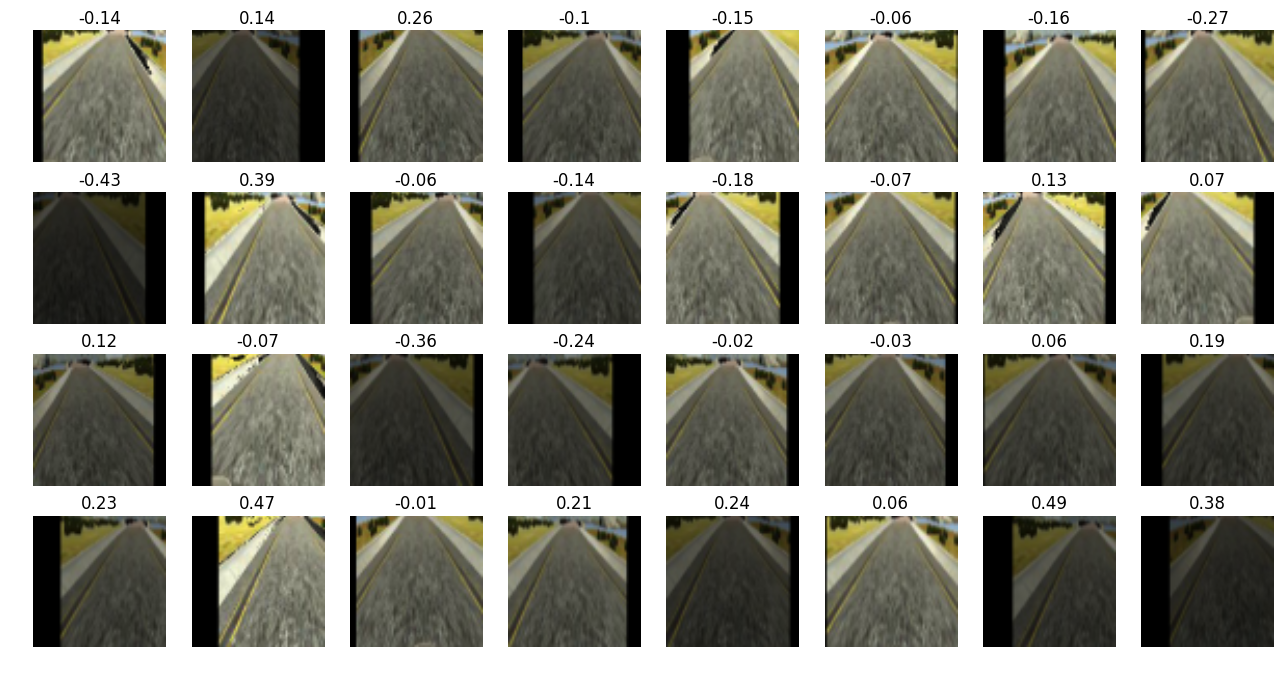

In [40]:
line_data = data_files_s.iloc[[2]].reset_index()
plt.figure(figsize=(16,8))
for i in range(32):
    image,steer = preprocess_image_file_train(line_data)

    plt.subplot(4,8,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))

### Keras generator and subsampling

As most of the car's driving was done along straight line, it is highly likely that the car is biased toward going straight. To remove this bias, I subsampled data to drop small angles with  probabilities. The drop probability was high in the initial part, and was reduced as training epochs progressed. 

In [41]:
pr_threshold = 1

def generate_train_from_PD_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, new_size_row, new_size_col, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data))
            line_data = data.iloc[[i_line]].reset_index()
            
            keep_pr = 0
            #x,y = preprocess_image_file_train(line_data)
            while keep_pr == 0:
                x,y = preprocess_image_file_train(line_data)
                pr_unif = np.random
                if abs(y)<.15:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            
            #x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            #y = np.array([[y]])
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

In [44]:
def generate_train_from_PD(data):
    while 1:
        i_line = np.random.randint(len(data))
        line_data = data.iloc[[i_line]].reset_index()
        x,y = preprocess_image_file_train(line_data)
        x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        y = np.array([[y]])
        yield x, y

def generate_valid_from_PD(data):
    while 1:
        for i_line in range(len(data)):
            line_data = data.iloc[[i_line]].reset_index()
            #print(line_data)
            x = preprocess_image_file_predict(data)
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
            y = line_data['steering'][0]
            y = np.array([[y]])
            yield x, y

        
valid_s_generator = generate_valid_from_PD(data_files_s)

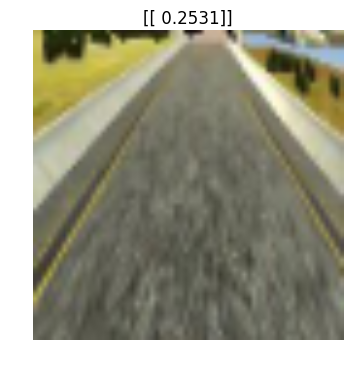

In [45]:
for i in range(100):
    next(valid_s_generator)
img,steer = next(valid_s_generator)
plt.imshow(img[0]);
plt.axis('off')
plt.title(str(np.round(steer,4)));

### Model architecture

<img src = small_model.png>

I implemented the model architecture above for training the data. The first layer is 3 1X1 filters, this has the effect of transforming the color space of the images. Research has shown that different color spaces are better suited for different applications. As we do not know the best color space apriori, using 3 1X1 filters allows the model to choose its best color space. This is followed by 3 convolutional blocks each comprised of 32, 64 and 128 filters of size 3X3. These convolution layers were followed by 3 fully connected layers. All the convolution blocks and the 2 following fully connected layers had leaky relu as activation function. I chose leaky relu to make transition between angles smoother.

In [46]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Convolution2D, MaxPooling2D, Flatten
from keras import initializations

Using TensorFlow backend.


In [47]:
import tensorflow as tf
#tf.python.control_flow_ops = tf

new_size_row = 64
new_size_col = 64

input_shape = (new_size_row, new_size_col, 3)


filter_size = 3

pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/255.-0.5,input_shape=input_shape))

model.add(Convolution2D(3,1,1,
                        border_mode='valid',
                        name='conv0', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv1', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(32,filter_size,filter_size,
                        border_mode='valid',
                        name='conv2', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv3', init='he_normal'))
model.add(ELU())

model.add(Convolution2D(64,filter_size,filter_size,
                        border_mode='valid',
                        name='conv4', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv5', init='he_normal'))
model.add(ELU())
model.add(Convolution2D(128,filter_size,filter_size,
                        border_mode='valid',
                        name='conv6', init='he_normal'))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512,name='hidden1', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',init='he_normal'))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', init='he_normal'))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv0 (Convolution2D)            (None, 64, 64, 3)     12          lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 64, 64, 3)     0           conv0[0][0]                      
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 62, 62, 32)    896         elu_1[0][0]                      
___________________________________________________________________________________________

In [48]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='mse')


### Training


I trained the model using the keras generator with batch size of 256 for 8 epochs. In each epoch, I generated 20000 images. I started with pr_threshold, the chance of dropping data with small angles as 1, and reduced the probability by dividing it by the iteration number after each epoch. The entire training took about 5 minutes. However, it too more than 20 hours to arrive at the right architecture and training parameters.

In [49]:
from pathlib import Path
import json

def save_model(fileModelJSON,fileWeights):
    #print("Saving model to disk: ",fileModelJSON,"and",fileWeights)
    if Path(fileModelJSON).is_file():
        os.remove(fileModelJSON)
    json_string = model.to_json()
    with open(fileModelJSON,'w' ) as f:
        json.dump(json_string, f)
    if Path(fileWeights).is_file():
        os.remove(fileWeights)
    #model.save_weights(fileWeights)
    model.save(fileWeights)

In [50]:
val_size = len(data_files_s)
train_size = len(data_files_s)
pr_threshold = 1

batch_size = 256

i_best = 0
val_best = 1000

for i_pr in range(10):

    train_r_generator = generate_train_from_PD_batch(data_files_s,batch_size)

    nb_vals = np.round(len(data_files_s)/val_size)-1
    history = model.fit_generator(train_r_generator,
            samples_per_epoch=7168, nb_epoch=1,validation_data=valid_s_generator,
                        nb_val_samples=val_size)
    
    fileModelJSON = 'model_' + str(i_pr) + '.json'
    fileWeights = 'model_' + str(i_pr) + '.h5'
    
    save_model(fileModelJSON,fileWeights)
    
    val_loss = history.history['val_loss'][0]
    if val_loss < val_best:
        i_best = i_pr 
        val_best = val_loss
        fileModelJSON = 'model_best.json'
        fileWeights = 'model_best.h5'
        save_model(fileModelJSON,fileWeights)
    
    
    pr_threshold = 1/(i_pr+1)
print('Best model found at iteration # ' + str(i_best))
print('Best Validation score : ' + str(np.round(val_best,4)))

Epoch 1/1
7168/7168 [==============================] - 254s - loss: 0.1062 - val_loss: 0.0173
Epoch 1/1
7168/7168 [==============================] - 151s - loss: 0.0821 - val_loss: 0.0166
Epoch 1/1
7168/7168 [==============================] - 94s - loss: 0.0615 - val_loss: 0.0167
Epoch 1/1
7168/7168 [==============================] - 73s - loss: 0.0564 - val_loss: 0.0175
Epoch 1/1
7168/7168 [==============================] - 65s - loss: 0.0540 - val_loss: 0.0168
Epoch 1/1
7168/7168 [==============================] - 60s - loss: 0.0485 - val_loss: 0.0165
Epoch 1/1
7168/7168 [==============================] - 58s - loss: 0.0494 - val_loss: 0.0175
Epoch 1/1
7168/7168 [==============================] - 54s - loss: 0.0489 - val_loss: 0.0167
Epoch 1/1
7168/7168 [==============================] - 53s - loss: 0.0447 - val_loss: 0.0190
Epoch 1/1
7168/7168 [==============================] - 54s - loss: 0.0437 - val_loss: 0.0240
Best model found at iteration # 5
Best Validation score : 0.0165
